This project will be all about defining and training a convolutional neural network to perform facial keypoint detection, and using computer vision techniques to transform images of faces. Facial keypoints (also called facial landmarks) are the small magenta dots shown on each of the faces in the image above. In each training and test image, there is a single face and 68 keypoints, with coordinates (x, y), for that face. These keypoints mark important areas of the face: the eyes, corners of the mouth, the nose, etc. These keypoints are relevant for a variety of tasks, such as face filters, emotion recognition, pose recognition, and so on. Here they are, numbered, and you can see that specific ranges of points match different portions of the face. <br>


This set of image data has been extracted from the YouTube Faces Dataset, which includes videos of people in YouTube videos. These videos have been fed through some processing steps and turned into sets of image frames containing one face and the associated keypoints.

This facial keypoints dataset consists of 5770 color images. All of these images are separated into either a training or a test set of data.

In [0]:
# importing neceesery libraries

import pandas as pd
import gc
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from albumentations import Flip,Compose,Normalize,Resize,RandomCrop
import torch.optim as optim
from albumentations.pytorch.transforms import ToTensor
import numpy as np
import torch
import torch.nn as nn
import os
import cv2
from skimage import io
import matplotlib.image as mpimg
from torchvision import transforms
import torch.nn.functional as F
import skimage


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
train_csv = 'data/training_frames_keypoints.csv'
train_dir = 'data/training'
test_csv = 'data/test_frames_keypoints.csv'
test_dir = 'data/test'


train_images = os.listdir(train_dir)
test_images = os.listdir(test_dir)

print(f'Length of train data is {len(train_images)}')
print(f'Length of test data is {len(test_images)}')

Length of train data is 3462
Length of test data is 2308


In [5]:
train_df = pd.read_csv(train_csv)
print(train_df.shape)
train_df.head()

(3462, 137)


,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,125.0,62.0,130.0,66.0,134.0,73.0,136.0,81.0,139.0,92.0,134.0,96.0,130.0,98.0,126.0,102.0,120.0,102.0,111.0,104.0,105.0,104.0,99.0,102.0,90.0,51.0,89.0,56.0,87.0,60.0,...,68.0,119.0,73.0,117.0,77.0,115.0,79.0,117.0,81.0,115.0,85.0,117.0,90.0,117.0,87.0,122.0,85.0,124.0,81.0,124.0,77.0,124.0,73.0,121.0,70.0,119.0,77.0,119.0,79.0,119.0,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,119.0,58.0,130.0,64.0,136.0,73.0,141.0,85.0,143.0,96.0,137.0,102.0,131.0,107.0,124.0,109.0,114.0,111.0,105.0,111.0,97.0,111.0,88.0,111.0,78.0,51.0,83.0,56.0,81.0,62.0,...,70.0,122.0,75.0,122.0,81.0,120.0,83.0,120.0,85.0,120.0,90.0,120.0,94.0,120.0,90.0,124.0,87.0,126.0,83.0,126.0,79.0,126.0,75.0,124.0,70.0,122.0,79.0,122.0,83.0,122.0,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,103.0,60.0,111.0,62.0,116.0,67.0,122.0,75.0,127.0,86.0,127.0,96.0,123.0,105.0,121.0,113.0,114.0,118.0,106.0,122.0,100.0,124.0,91.0,128.0,81.0,58.0,56.0,62.0,54.0,67.0,...,67.0,103.0,69.0,101.0,73.0,101.0,75.0,101.0,77.0,101.0,84.0,103.0,88.0,108.0,82.0,110.0,77.0,110.0,75.0,110.0,71.0,110.0,69.0,107.0,67.0,103.0,73.0,103.0,75.0,105.0,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,132.0,61.0,141.0,64.0,148.0,73.0,157.0,85.0,163.0,101.0,163.0,116.0,164.0,128.0,161.0,137.0,155.0,144.0,143.0,150.0,134.0,156.0,121.0,162.0,109.0,70.0,68.0,76.0,65.0,85.0,...,76.0,129.0,82.0,130.0,88.0,127.0,91.0,130.0,98.0,130.0,104.0,133.0,110.0,139.0,101.0,142.0,95.0,145.0,88.0,142.0,82.0,142.0,79.0,139.0,76.0,129.0,85.0,133.0,91.0,133.0,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,130.0,71.0,136.0,75.0,138.0,81.0,141.0,92.0,143.0,105.0,139.0,113.0,135.0,122.0,129.0,126.0,122.0,128.0,112.0,130.0,103.0,130.0,95.0,130.0,86.0,58.0,81.0,60.0,74.0,64.0,...,75.0,121.0,79.0,117.0,84.0,115.0,86.0,115.0,90.0,113.0,96.0,115.0,103.0,118.0,98.0,122.0,92.0,124.0,88.0,124.0,84.0,126.0,79.0,124.0,77.0,121.0,84.0,117.0,88.0,117.0,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [6]:
test_df = pd.read_csv(test_csv)
print(test_df.shape)
test_df.head()

(770, 137)


,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,James_Wolfensohn_00.jpg,25.0,44.0,25.0,49.0,25.0,54.0,25.0,59.0,26.0,64.0,27.0,67.0,30.0,71.0,33.0,75.0,39.0,76.0,46.0,76.0,52.0,74.0,56.0,72.0,59.0,67.0,62.0,62.0,63.0,57.0,64.0,52.0,65.0,47.0,27.0,40.0,30.0,39.0,32.0,...,33.0,65.0,36.0,64.0,38.0,64.0,39.0,65.0,41.0,64.0,44.0,65.0,47.0,65.0,44.0,66.0,42.0,68.0,39.0,68.0,37.0,68.0,36.0,66.0,33.0,65.0,38.0,65.0,39.0,65.0,42.0,65.0,46.0,65.0,42.0,65.0,39.0,65.0,38.0,65.0
1,Valerie_Harper_30.jpg,55.0,62.0,52.0,72.0,52.0,83.0,55.0,90.0,55.0,101.0,57.0,108.0,60.0,114.0,65.0,121.0,75.0,127.0,88.0,124.0,98.0,122.0,106.0,117.0,114.0,112.0,122.0,102.0,124.0,94.0,129.0,87.0,129.0,76.0,57.0,52.0,60.0,50.0,65.0,...,65.0,101.0,68.0,101.0,70.0,98.0,75.0,101.0,78.0,101.0,83.0,104.0,88.0,106.0,83.0,109.0,78.0,109.0,73.0,109.0,70.0,109.0,68.0,106.0,65.0,101.0,70.0,104.0,75.0,104.0,78.0,104.0,88.0,106.0,78.0,106.0,75.0,104.0,70.0,104.0
2,Kristen_Breitweiser_11.jpg,60.0,88.0,60.0,98.0,63.0,109.0,65.0,116.0,68.0,127.0,73.0,135.0,78.0,137.0,83.0,140.0,96.0,143.0,109.0,138.0,119.0,135.0,127.0,130.0,132.0,125.0,135.0,115.0,135.0,105.0,137.0,95.0,137.0,84.0,63.0,75.0,65.0,70.0,71.0,...,78.0,119.0,83.0,114.0,89.0,112.0,91.0,112.0,94.0,112.0,101.0,112.0,109.0,117.0,101.0,120.0,96.0,122.0,94.0,122.0,89.0,122.0,83.0,122.0,81.0,119.0,89.0,117.0,91.0,114.0,96.0,114.0,106.0,117.0,96.0,117.0,94.0,117.0,89.0,117.0
3,Elizabeth_Dole_31.jpg,41.0,96.0,43.0,104.0,47.0,113.0,49.0,120.0,56.0,128.0,64.0,135.0,73.0,139.0,83.0,144.0,96.0,144.0,105.0,137.0,107.0,133.0,107.0,127.0,109.0,120.0,109.0,112.0,109.0,103.0,109.0,95.0,107.0,86.0,60.0,83.0,66.0,79.0,73.0,...,83.0,122.0,90.0,120.0,94.0,116.0,98.0,116.0,100.0,116.0,103.0,116.0,103.0,118.0,103.0,122.0,100.0,125.0,98.0,127.0,94.0,127.0,90.0,124.0,83.0,122.0,94.0,120.0,96.0,118.0,98.0,118.0,103.0,118.0,98.0,120.0,96.0,122.0,94.0,122.0
4,Kit_Bond_20.jpg,35.0,67.0,37.0,74.0,41.0,81.0,44.0,87.0,48.0,96.0,51.0,103.0,58.0,108.0,66.0,112.0,76.0,112.0,85.0,107.0,91.0,100.0,94.0,93.0,96.0,84.0,96.0,77.0,96.0,70.0,96.0,64.0,94.0,55.0,42.0,67.0,48.0,65.0,51.0,...,60.0,94.0,64.0,96.0,69.0,94.0,73.0,94.0,74.0,94.0,80.0,94.0,83.0,93.0,80.0,98.0,78.0,101.0,73.0,101.0,69.0,101.0,66.0,99.0,60.0,94.0,69.0,96.0,73.0,96.0,76.0,96.0,83.0,93.0,76.0,98.0,73.0,98.0,69.0,98.0


# Display sample image

In [0]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='lightgreen')


Olene_Walker_41.jpg
(197, 200, 4)


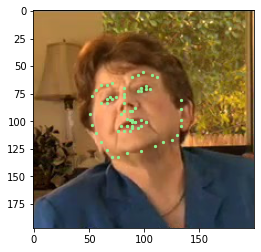

In [8]:
image_name = train_images[197]
print(image_name)
keypts = train_df[train_df['Unnamed: 0'] == image_name].values[0][1:].astype('float').reshape(-1,2)


image = io.imread(os.path.join(train_dir,image_name))
image = skimage.img_as_float(image)
print(image.shape)
show_keypoints(image,keypts)


## Transforms and Data Loading

Now, the images above are not of the same size, and neural networks often expect images that are standardized; a fixed size, with a normalized range for color ranges and coordinates, and (for PyTorch) converted from numpy lists and arrays to Tensors.

Therefore, we will need to write some pre-processing code. Let's create four transforms:<br>
* Normalize: to convert a color image to grayscale values with a range of [0,1] and normalize the keypoints to be in a range of about [-1, 1]
* Rescale: to rescale an image to a desired size.
* RandomCrop: to crop an image randomly.
* ToTensor: to convert numpy images to torch images. 

In [0]:
class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0


        return {'image': image_copy, 'keypoints': key_pts_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:  #(100,80).. 100 > 80 so newh , new_w = 100 * (100/80),240
                new_h, new_w = self.output_size * h / w, self.output_size   
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}



In [0]:
class FaceData(Dataset):
  def __init__(self,point_file,image_folder,transform=None):
      self.df = pd.read_csv(point_file)
      self.image_folder = image_folder
      self.images = self.df['Unnamed: 0'].values
      self.transform = transform

  def __len__(self):
      return len(self.images)

  def __getitem__(self,idx):

      img = self.images[idx]
      # image = io.imread(os.path.join(self.image_folder,img))
     
      image = mpimg.imread(os.path.join(self.image_folder,img))
      # if image has an alpha color channel, get rid of it
      if(image.shape[2] == 4):
            image = image[:,:,0:3]

      image = np.float32(image)

      key_pts = self.df[self.df['Unnamed: 0'] == img].values[0][1:].astype('float').reshape(-1,2)

      # key_pts = self.df.iloc[idx, 1:].as_matrix()
      # key_pts = key_pts.astype('float').reshape(-1, 2)


      sample = {'image': image, 'keypoints': key_pts}

      if self.transform:
          sample = self.transform(sample)

      return sample

## Sample check on how transforms work

Length of dataset:  3462


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


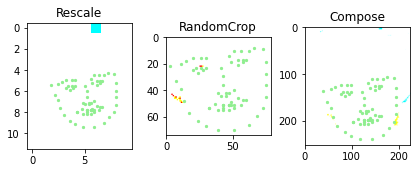

In [11]:
face_dataset = FaceData(point_file=train_csv,image_folder=train_dir,transform=None)
print('Length of dataset: ', len(face_dataset))


# test out some of these transforms
rescale = Rescale(10)
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])

# apply the transforms to a sample image
test_num = 100
sample = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()



## Loading train and test data

In [29]:
transform_ = transforms.Compose([Rescale(250),
                                    RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])




train_dataset = FaceData(point_file=train_csv,image_folder=train_dir,transform=transform_)
print('Length of dataset: ', len(face_dataset))




test_dataset = FaceData(test_csv,test_dir,transform_)
print('Length of dataset: ', len(test_dataset))


Length of dataset:  3462
Length of dataset:  770


In [30]:
for data in train_dataset:
  print(data['image'].shape)
  print(data['keypoints'].shape)
  break

torch.Size([1, 224, 224])
torch.Size([68, 2])


In [31]:
for data in test_dataset:
  print(data['image'].shape)
  print(data['keypoints'].shape)
  break

torch.Size([1, 224, 224])
torch.Size([68, 2])


## visualizations

In [0]:
def image_kpconvert(image,kpts):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    kpts = (kpts*50) + 100 #denormalize keypoints
    return image,kpts

def plot_img(data,idx):
    out = data.__getitem__(idx)
    image,key_pts = image_kpconvert(out['image'],out['keypoints'])
    plt.imshow(np.squeeze(image),cmap='gray')
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')



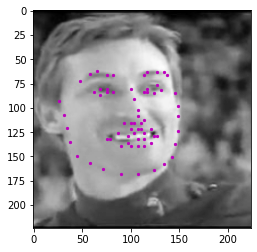

In [33]:
plot_img(train_dataset,12)

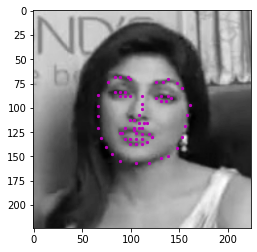

In [34]:
plot_img(train_dataset,117)

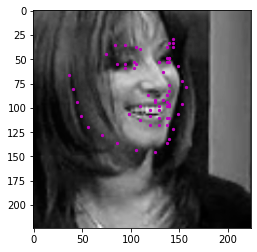

In [35]:
plot_img(test_dataset,117)

## Loading in batches

In [0]:

# tr = int(0.8*len(face_dataset))
# val = len(face_dataset) - int(0.8*len(face_dataset))
# trainset, valset = random_split(face_dataset, [tr,val])

train_loader = DataLoader(dataset=train_dataset, batch_size=5, shuffle=True,num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=5)

In [37]:
for data in train_loader:
  print(data['image'].shape)
  print(data['keypoints'].shape)
  break

torch.Size([5, 1, 224, 224])
torch.Size([5, 68, 2])


In [38]:
for data in test_loader:
  print(data['image'].shape)
  print(data['keypoints'].shape)
  break

torch.Size([5, 1, 224, 224])
torch.Size([5, 68, 2])


# Model Creation

In [0]:
class Net(nn.Module):
  def __init__(self):
        super(Net, self).__init__()
       
        #defining maxpool block
        self.maxpool = nn.MaxPool2d(2, 2)
               
        #defining dropout block
        self.dropout = nn.Dropout(p=0.2)
        
        self.conv1 = nn.Conv2d(1, 32, 5)
        
        #defining second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, 3)
        
        #defining third convolutional layer
        self.conv3 = nn.Conv2d(64, 128, 3)
        
        #defining linear output layer
        self.fc1 = nn.Linear(128*26*26, 136)


  def forward(self, x):
        
        #passing tensor x through first conv layer
        x = self.maxpool(F.relu(self.conv1(x)))
     
        #passing tensor x through second conv layer
        x = self.maxpool(F.relu(self.conv2(x)))
        
        #passing tensor x through third conv layer
        x = self.maxpool(F.relu(self.conv3(x)))
        
      
        #flattening x tensor
        x = x.view(x.size(0), -1)
        
        #applying dropout
        x = self.dropout(x)
     
        #passing x through linear layer
        x = self.fc1(x)
        
        #returning x
        return x

In [44]:
model = Net()
model = model.to(device)
model

Net(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=86528, out_features=136, bias=True)
)

In [0]:
# test the model on a batch of test images
def net_sample_output():
    
    # iterate through the test dataset
    for i,sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']
        key_pts = key_pts.view(key_pts.size(0), -1)
        # convert variables to floats for regression loss
        images = images.to(device,dtype=torch.float)
        key_pts = key_pts.to(device,dtype=torch.float)
        output_pts = model(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size(0),68,-1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts



In [46]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, val_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(val_outputs.data.size())
print(gt_pts.size())

torch.Size([5, 1, 224, 224])
torch.Size([5, 68, 2])
torch.Size([5, 136])


## Training

In [0]:
criterion = nn.MSELoss()#defining the optimizer method, for gradient descent
optimizer = optim.Adam(model.parameters(), lr = 0.0005)
epochs = 10


total_train_loss = []
total_test_loss = []

model.train()
    
for epoch in range(epochs):

        model.train()

        print(f'Epoch: {epoch+1}')
        running_loss = 0.0
        for data in train_loader:
            images = data['image']
            key_pts = data['keypoints']
            key_pts = key_pts.view(key_pts.size(0), -1)
            # convert variables to floats for regression loss
            images = images.to(device,dtype=torch.float)
            key_pts = key_pts.to(device,dtype=torch.float)
            key_pts_pred = model(images)
            loss = criterion(key_pts_pred,key_pts)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_train_loss = running_loss/len(test_loader.dataset)
        total_train_loss.append(epoch_train_loss)

        print(f'Train loss is {epoch_train_loss}')
        

        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            for data in test_loader:
                  images = data['image']
                  key_pts = data['keypoints']
                  key_pts = key_pts.view(key_pts.size(0), -1)
                  # convert variables to floats for regression loss
                  images = images.to(device,dtype=torch.float)
                  key_pts = key_pts.to(device,dtype=torch.float)
                  key_pts_pred = model(images)
                  loss = criterion(key_pts_pred,key_pts)
                  running_loss += loss.item()


        epoch_test_loss = running_loss/len(test_loader.dataset)
        total_test_loss.append(epoch_test_loss)

        print(f'Validation loss is {epoch_test_loss}')
        
        
print('Finished Training')
  


Epoch: 1
Train loss is 0.15359805601999743


In [0]:
#saving model
torch.save(model.state_dict(),'model_may14.pt')

In [0]:
plt.figure(figsize=(10,10))
plt.plot(total_train_loss,label='train_loss')
plt.plot(total_test_loss,label='test_loss')
plt.title('Loss Plot')
plt.legend()
plt.show()